In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt



In [57]:
locA_solar_sensor = []
locB_solar_sensor = []

for i in range(1,45):
    try:
        t = pd.read_csv(f"../Datasets/Anti_Anomaly_data/Anti_Anomaly_A{i}_df.csv")
        t['DATE_TIME'] = pd.to_datetime(t['DATE_TIME'])
        locA_solar_sensor.append(t)
    except Exception as e:
        locA_solar_sensor.append([])
    try:
        t = pd.read_csv(f"../Datasets/Anti_Anomaly_data/Anti_Anomaly_B{i}_df.csv")
        t['DATE_TIME'] = pd.to_datetime(t['DATE_TIME'])
        locB_solar_sensor.append(t)
    except Exception as e:
        locB_solar_sensor.append([])


In [58]:
final_locA = []
final_locB = []

def preprocess_data(locA_solar_sensor,locB_solar_sensor):
    locA_models = []
    locB_models = []

    for i in range(len(locA_solar_sensor)):
        if len(locA_solar_sensor[i]) > 0:

            current_sensor = locA_solar_sensor[i].copy()
            # Add season and time period columns
            current_sensor.loc[:, 'SEASON'] = current_sensor['DATE_TIME'].dt.month.map({
                12: 1, 1: 1, 2: 1,
                3: 2, 4: 2, 5: 2,
                6: 3, 7: 3, 8: 3,
                9: 4, 10: 4, 11: 4})

            current_sensor.loc[:, 'TIME_PERIOD'] = pd.cut(current_sensor['DATE_TIME'].dt.hour,
                                                    bins=[0, 6, 12, 15, 20, 24],
                                                    labels=[1, 2, 3, 4, 5],
                                                    include_lowest=True)

            # Create dummy variables
            season_encoded = pd.get_dummies(current_sensor['SEASON'].astype(str), prefix='Season')
            time_period_encoded = pd.get_dummies(current_sensor['TIME_PERIOD'].astype(str), prefix='TimePeriod')
            current_sensor = pd.concat([current_sensor, season_encoded, time_period_encoded], axis=1)
            current_sensor = current_sensor.drop(['SEASON', 'TIME_PERIOD'], axis=1)

            # Prepare features and target
            X = current_sensor[['Conversion_Efficiency','Normalized_Power','Energy_Per_Irradiation','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION'] +
                        list(season_encoded.columns) + list(time_period_encoded.columns)]
            y = current_sensor['AC_POWER']

            final_locA.append([X, y])
        else:
            final_locA.append([[],[]])

    print("*************************************","Location A: ",len(final_locA))
    # Process Location B sensors
    for i in range(len(locB_solar_sensor)):
        if len(locB_solar_sensor[i])>0:

            current_sensor = locB_solar_sensor[i].copy()
            # Add season and time period columns
            current_sensor.loc[:,'SEASON'] = current_sensor['DATE_TIME'].dt.month.map({12:1, 1:1, 2:1,
                                                            3:2, 4:2, 5:2,
                                                            6:3, 7:3, 8:3, 
                                                            9:4, 10:4, 11:4})

            current_sensor.loc[:,'TIME_PERIOD'] = pd.cut(current_sensor['DATE_TIME'].dt.hour, 
                                bins=[0, 6, 12, 15, 20, 24],
                                labels=[1, 2, 3, 4, 5],
                                include_lowest=True)

            # Create dummy variables
            season_encoded = pd.get_dummies(current_sensor['SEASON'].astype(str), prefix='Season')
            time_period_encoded = pd.get_dummies(current_sensor['TIME_PERIOD'].astype(str), prefix='TimePeriod')
            current_sensor = pd.concat([current_sensor, season_encoded, time_period_encoded], axis=1)
            current_sensor = current_sensor.drop(['SEASON', 'TIME_PERIOD'], axis=1)
            
            # Prepare features and target
            X = current_sensor[['Conversion_Efficiency','Normalized_Power','Energy_Per_Irradiation','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION'] +
                        list(season_encoded.columns) + list(time_period_encoded.columns)]
            y = current_sensor['AC_POWER']

            if len(X) > 0:  # Only append if there is data
                final_locB.append([X,y])
        else:
            final_locB.append([[],[]])

    print("*************************************","Location B: ",len(final_locB))

    # Train and evaluate models
    total_mse_A = 0
    total_r2_A = 0
    count_A = 0

    for i, sensor_data in enumerate(final_locA):
        if len(sensor_data[0]) == 0:
            locA_models.append(None)
            continue
        if sensor_data[0].shape[0] >= 5:  # Ensure enough data to split
            model, mse, r2 = train_sensor_model(sensor_data[0], sensor_data[1])
            locA_models.append(model)
            total_mse_A += mse
            total_r2_A += r2
            count_A += 1
            # print(f"Model trained for sensor {i+1}, Location: A")
            # print(f"MSE: {mse:.4f}, R2 Score: {r2:.4f}")
        else:
            # print(f"Insufficient data for model training - Sensor {i+1}, Location: A")
            locA_models.append(None)

    if count_A > 0:
        print(f"\nLocation A Overall Metrics:")
        print(f"Average MSE: {total_mse_A/count_A:.4f}")
        print(f"Average R2 Score: {total_r2_A/count_A:.4f}")

    total_mse_B = 0 
    total_r2_B = 0
    count_B = 0

    for i, sensor_data in enumerate(final_locB):
        if len(sensor_data[0]) == 0:
            locB_models.append(None)
            continue
        if sensor_data[0].shape[0] >= 5:  # Ensure enough data to split
            model, mse, r2 = train_sensor_model(sensor_data[0], sensor_data[1])
            locB_models.append(model)
            total_mse_B += mse
            total_r2_B += r2
            count_B += 1
            # print(f"Model trained for sensor {i+1}, Location: B")
            # print(f"MSE: {mse:.4f}, R2 Score: {r2:.4f}")
        else:
            # print(f"No data for Sensor {i+1}, Location: B")
            locB_models.append(None)

    if count_B > 0:
        print(f"\nLocation B Overall Metrics:")
        print(f"Average MSE: {total_mse_B/count_B:.4f}")
        print(f"Average R2 Score: {total_r2_B/count_B:.4f}")
    return locA_models,locB_models


In [59]:
def test_model(locA_models,locB_models,model_type):
    locA_solar_sensor = []
    locB_solar_sensor = []

    for i in range(1, 45):
        try:
            t = pd.read_csv(f"../Datasets/sensor_wise_data/A{i}_df.csv")
            t['DATE_TIME'] = pd.to_datetime(t['DATE_TIME'])
            locA_solar_sensor.append(t)
        except Exception as e:
            locA_solar_sensor.append([])
        try:
            t = pd.read_csv(f"../Datasets/sensor_wise_data/B{i}_df.csv")
            t['DATE_TIME'] = pd.to_datetime(t['DATE_TIME'])
            locB_solar_sensor.append(t)
        except Exception as e:
            locB_solar_sensor.append([])

    # Process Location A sensors
    for i in range(len(locA_solar_sensor)):
        if len(locA_solar_sensor[i]) > 0:
            current_sensor = locA_solar_sensor[i].copy()
            current_sensor['SEASON'] = current_sensor['DATE_TIME'].dt.month.map({
                12:1, 1:1, 2:1,
                3:2, 4:2, 5:2,
                6:3, 7:3, 8:3, 
                9:4, 10:4, 11:4})
            current_sensor['TIME_PERIOD'] = pd.cut(current_sensor['DATE_TIME'].dt.hour,
                                                    bins=[0, 6, 12, 15, 20, 24],
                                                    labels=[1, 2, 3, 4, 5],
                                                    include_lowest=True)
            # One-hot encode categorical variables
            season_encoded = pd.get_dummies(current_sensor['SEASON'].astype(str), prefix='Season')
            time_period_encoded = pd.get_dummies(current_sensor['TIME_PERIOD'].astype(str), prefix='TimePeriod')

            current_sensor = pd.concat([current_sensor, season_encoded, time_period_encoded], axis=1)
            current_sensor = current_sensor.drop(['SEASON', 'TIME_PERIOD'], axis=1)

            current_sensor.dropna(inplace=True)

            test_x = current_sensor[['Conversion_Efficiency','Normalized_Power','Energy_Per_Irradiation','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION'] +
                        list(season_encoded.columns)]
            if locA_models[i-1] is None:
                # print(f"Model for sensor {i} is not available.")
                continue
            for period in locA_models[i-1].feature_names_in_:
                if "TimePeriod_" in period:
                    test_x = test_x.copy() 
                    test_x.loc[:,period] = current_sensor[period]
            model = locA_models[i-1]
            
            
            sample_predictions = model.predict(test_x)
            
            # Calculate differences and z-score for anomaly detection
            comparison_df = pd.DataFrame({
                'Actual AC Power': current_sensor["AC_POWER"],
                'Predicted AC Power': sample_predictions,
                'Difference': current_sensor["AC_POWER"] - sample_predictions,
            })

            # Calculate z-score of differences
            z_scores = np.abs((comparison_df['Difference'] - comparison_df['Difference'].mean()) / comparison_df['Difference'].std())

            # Flag anomalies where z-score > 3 (3 standard deviations)
            anomalies = z_scores > 3

            # Add anomaly flags to original data
            temp_idx = current_sensor.index
            current_sensor.loc[temp_idx, 'IS_ANOMALY'] = anomalies

            saving_df = pd.DataFrame({
                'IS_ANOMALY': current_sensor['IS_ANOMALY'],
                'LOCATION': 'A',
                'DATE_TIME': current_sensor['DATE_TIME'],
                'SENSOR_NUMBER': i + 1,
                'DC_POWER': current_sensor['DC_POWER'],
                'AC_POWER': current_sensor['AC_POWER'],
                'DAILY_YIELD': current_sensor['DAILY_YIELD'],
                'TOTAL_YIELD': current_sensor['TOTAL_YIELD'],
            })
            
            if model_type == 0:
                saving_df.to_csv(f"Model_Results/LinearRegression/A{i+1}_df.csv",index=False)
            elif model_type == 1:
                saving_df.to_csv(f"Model_Results/RandomForest/A{i+1}_df.csv",index=False)
            elif model_type == 2:
                saving_df.to_csv(f"Model_Results/GradientBoosting/A{i+1}_df.csv",index=False)

            print(f"\nDetected {anomalies.sum()} anomalies for sensor {i}")
            # print("\nSample anomalous readings:")

            locA_solar_sensor[i] = current_sensor
        else:
            locA_solar_sensor.append([])
    # Process Location B sensors
    for i in range(len(locB_solar_sensor)):
        if len(locB_solar_sensor[i]) > 0:
            current_sensor = locB_solar_sensor[i].copy()
            current_sensor['SEASON'] = current_sensor['DATE_TIME'].dt.month.map({
                12:1, 1:1, 2:1,
                3:2, 4:2, 5:2,
                6:3, 7:3, 8:3, 
                9:4, 10:4, 11:4})
            current_sensor['TIME_PERIOD'] = pd.cut(current_sensor['DATE_TIME'].dt.hour,
                                                    bins=[0, 6, 12, 15, 20, 24],
                                                    labels=[1, 2, 3, 4, 5],
                                                    include_lowest=True)
            # One-hot encode categorical variables
            season_encoded = pd.get_dummies(current_sensor['SEASON'].astype(str), prefix='Season')
            time_period_encoded = pd.get_dummies(current_sensor['TIME_PERIOD'].astype(str), prefix='TimePeriod')

            current_sensor = pd.concat([current_sensor, season_encoded, time_period_encoded], axis=1)
            current_sensor = current_sensor.drop(['SEASON', 'TIME_PERIOD'], axis=1)

            current_sensor.dropna(inplace=True)

            test_x = current_sensor[['Conversion_Efficiency','Normalized_Power','Energy_Per_Irradiation','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION'] +
                        list(season_encoded.columns)]
            if locB_models[i-1] is None:
                # print(f"Model for sensor {i} is not available.")
                continue
            for period in locB_models[i-1].feature_names_in_:
                if "TimePeriod_" in period:
                    test_x = test_x.copy() 
                    test_x.loc[:,period] = current_sensor[period]
            model = locB_models[i-1]

            sample_predictions = model.predict(test_x)

            # Calculate differences and z-score for anomaly detection
            comparison_df = pd.DataFrame({
                'Actual AC Power': current_sensor["AC_POWER"],
                'Predicted AC Power': sample_predictions,
                'Difference': current_sensor["AC_POWER"] - sample_predictions
            })

            # Calculate z-score of differences
            z_scores = np.abs((comparison_df['Difference'] - comparison_df['Difference'].mean()) / comparison_df['Difference'].std())

            # Flag anomalies where z-score > 3 (3 standard deviations)
            anomalies = z_scores > 3

            # Add anomaly flags to original data
            temp_idx = current_sensor.index
            current_sensor.loc[temp_idx, 'IS_ANOMALY'] = anomalies

            saving_df = pd.DataFrame({
                'IS_ANOMALY': current_sensor['IS_ANOMALY'],
                'LOCATION': 'B',
                'DATE_TIME': current_sensor['DATE_TIME'],
                'SENSOR_NUMBER': i + 1,
                'DC_POWER': current_sensor['DC_POWER'],
                'AC_POWER': current_sensor['AC_POWER'],
                'DAILY_YIELD': current_sensor['DAILY_YIELD'],
                'TOTAL_YIELD': current_sensor['TOTAL_YIELD'],
            })

            if model_type == 0:
                saving_df.to_csv(f"Model_Results/LinearRegression/B{i+1}_df.csv",index=False)
            elif model_type == 1:
                saving_df.to_csv(f"Model_Results/RandomForest/B{i+1}_df.csv",index=False)
            elif model_type == 2:
                saving_df.to_csv(f"Model_Results/GradientBoosting/B{i+1}_df.csv",index=False)

            print(f"\nDetected {anomalies.sum()} anomalies for sensor {i}")
            # print("\nSample anomalous readings:")
            # print(comparison_df[anomalies].head())

            locB_solar_sensor[i] = current_sensor
        else:
            locB_solar_sensor.append([])
    # Plotting anomalies detected in Location A
    plt.figure(figsize=(15, 10))
    plt.suptitle('Anomalies Detected in Location A', fontsize=16)

    for i in range(len(locA_solar_sensor)):
        if len(locA_solar_sensor[i]) == 0:
            continue
        anomaly_col = 'IS_ANOMALY'
        if anomaly_col in locA_solar_sensor[i].columns:
            sensor_data = locA_solar_sensor[i]
            if not sensor_data.empty and sensor_data[anomaly_col].any():
                anomalies = sensor_data[sensor_data[anomaly_col]]
                plt.scatter(anomalies['DATE_TIME'], 
                            [i] * len(anomalies), 
                            label=f'Sensor {i+1}',
                            alpha=0.6)

    plt.ylabel('Sensor Number')
    plt.xlabel('Date Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()

    # Create separate figure for Location B
    plt.figure(figsize=(15, 10))
    plt.suptitle('Anomalies Detected in Location B', fontsize=16)

    for i in range(len(locB_solar_sensor)):
        if len(locB_solar_sensor[i]) == 0:
            continue
        anomaly_col = 'IS_ANOMALY'
        if anomaly_col in locB_solar_sensor[i]:
            sensor_data = locB_solar_sensor[i]
            if not sensor_data.empty and sensor_data[anomaly_col].any():
                anomalies = sensor_data[sensor_data[anomaly_col]]
                plt.scatter(anomalies['DATE_TIME'], 
                            [i] * len(anomalies),
                            label=f'Sensor {i+1}',
                            alpha=0.6)

    plt.ylabel('Sensor Number')
    plt.xlabel('Date Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

Linear Regression
************************************* Location A:  44
************************************* Location B:  44

Location A Overall Metrics:
Average MSE: 986.0062
Average R2 Score: 0.9923

Location B Overall Metrics:
Average MSE: 15839.6510
Average R2 Score: 0.8606

Detected 39 anomalies for sensor 0

Detected 19 anomalies for sensor 1

Detected 39 anomalies for sensor 2

Detected 44 anomalies for sensor 19

Detected 40 anomalies for sensor 23

Detected 17 anomalies for sensor 24

Detected 34 anomalies for sensor 25

Detected 23 anomalies for sensor 26

Detected 36 anomalies for sensor 27

Detected 37 anomalies for sensor 36

Detected 34 anomalies for sensor 42

Detected 39 anomalies for sensor 43

Detected 14 anomalies for sensor 8

Detected 14 anomalies for sensor 9

Detected 7 anomalies for sensor 10

Detected 13 anomalies for sensor 13

Detected 157 anomalies for sensor 14

Detected 89 anomalies for sensor 15

Detected 168 anomalies for sensor 16

Detected 17 anomalie

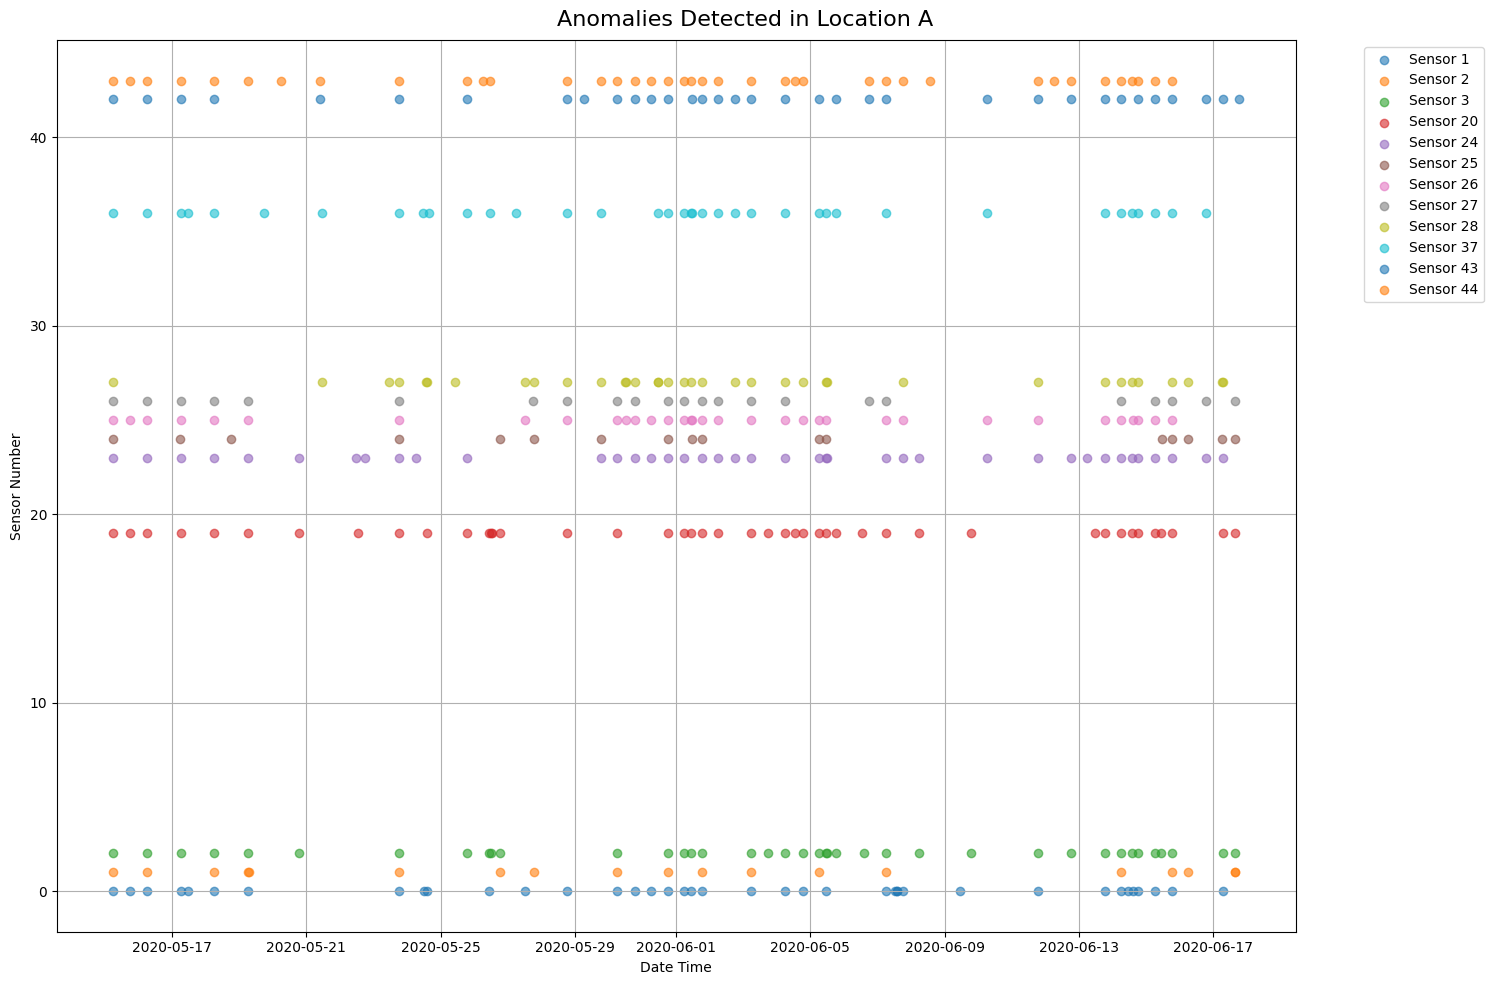

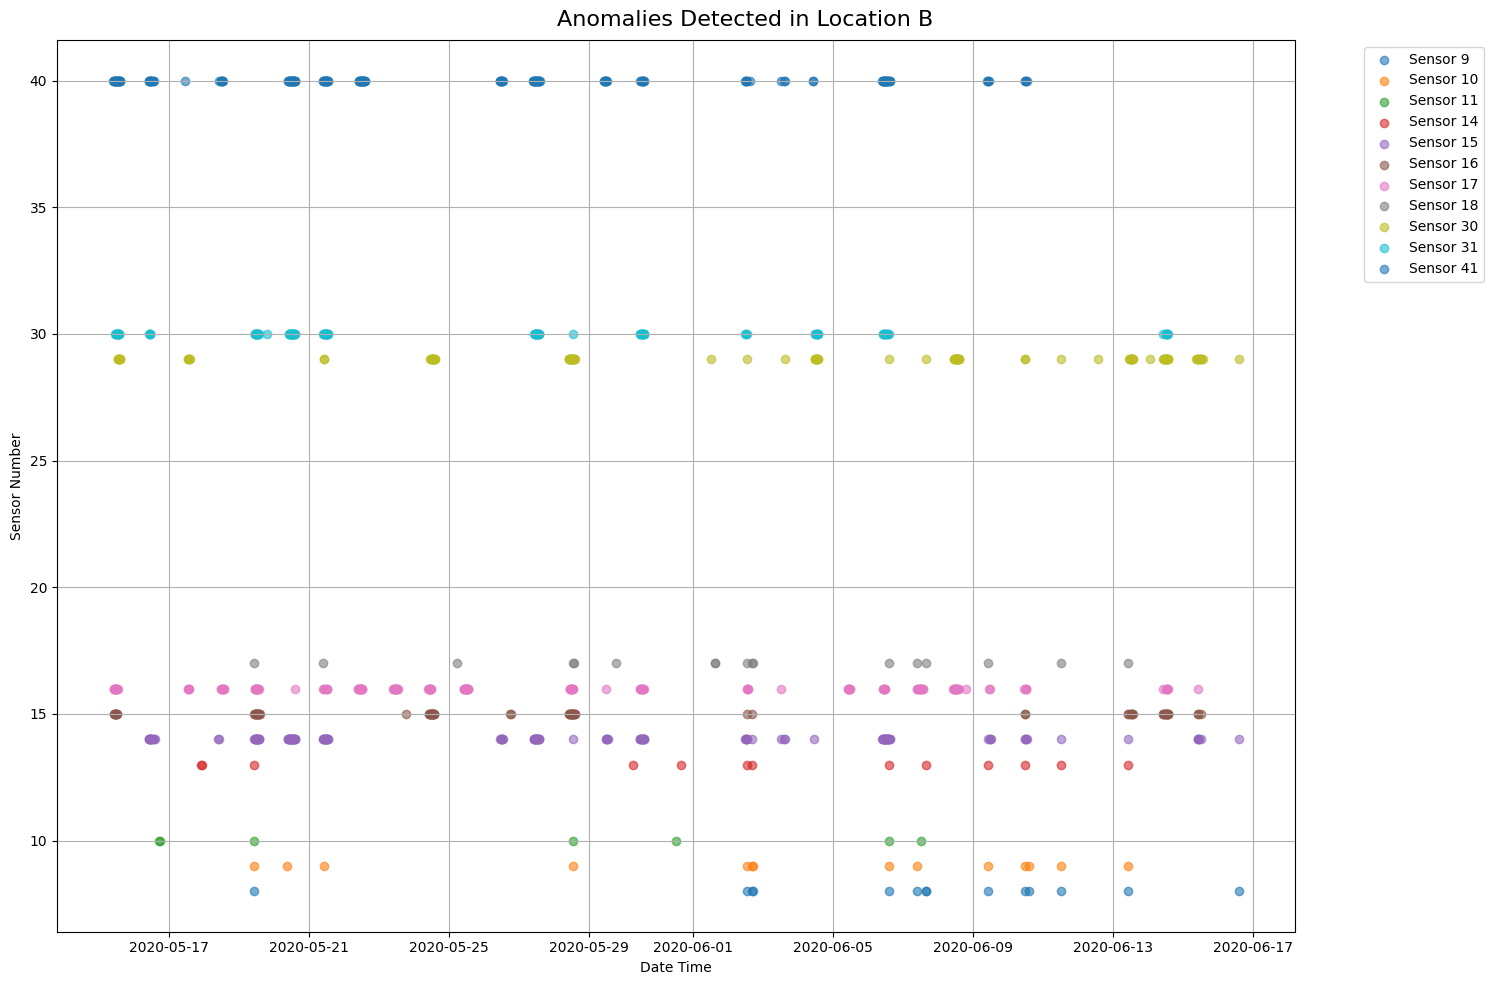

Random Forest
************************************* Location A:  44
************************************* Location B:  44

Location A Overall Metrics:
Average MSE: 417.4443
Average R2 Score: 0.9967

Location B Overall Metrics:
Average MSE: 317.8780
Average R2 Score: 0.9974

Detected 14 anomalies for sensor 0

Detected 35 anomalies for sensor 1

Detected 30 anomalies for sensor 2

Detected 33 anomalies for sensor 19

Detected 25 anomalies for sensor 23

Detected 35 anomalies for sensor 24

Detected 23 anomalies for sensor 25

Detected 39 anomalies for sensor 26

Detected 45 anomalies for sensor 27

Detected 31 anomalies for sensor 36

Detected 32 anomalies for sensor 42

Detected 36 anomalies for sensor 43

Detected 65 anomalies for sensor 8

Detected 231 anomalies for sensor 9

Detected 73 anomalies for sensor 10

Detected 49 anomalies for sensor 13

Detected 179 anomalies for sensor 14

Detected 75 anomalies for sensor 15

Detected 97 anomalies for sensor 16

Detected 126 anomalies fo

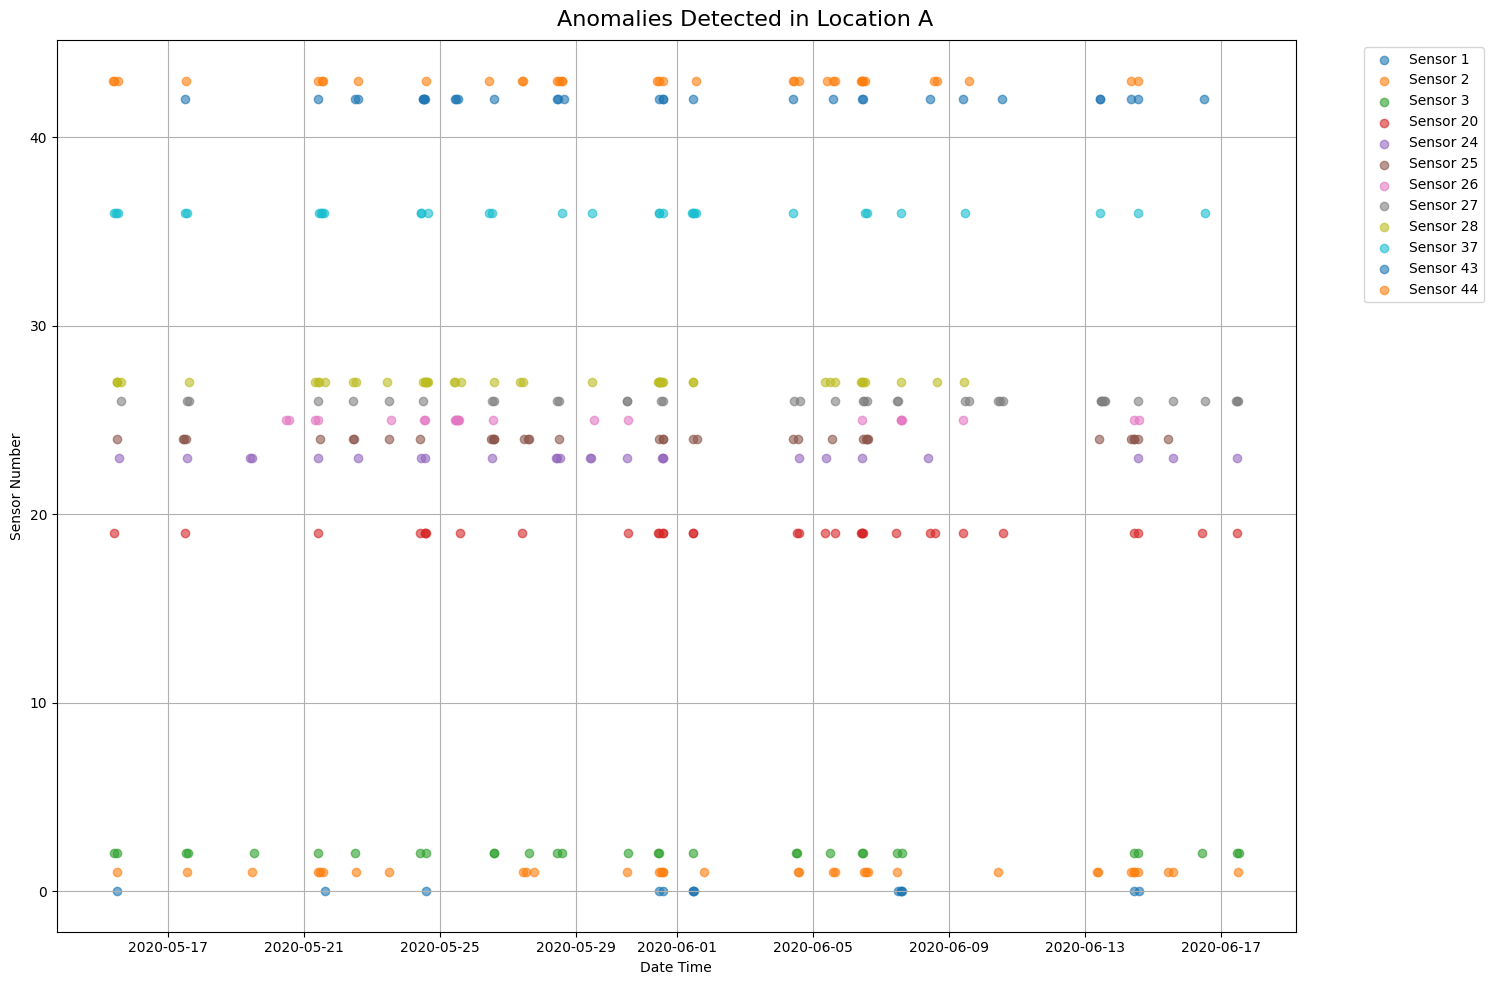

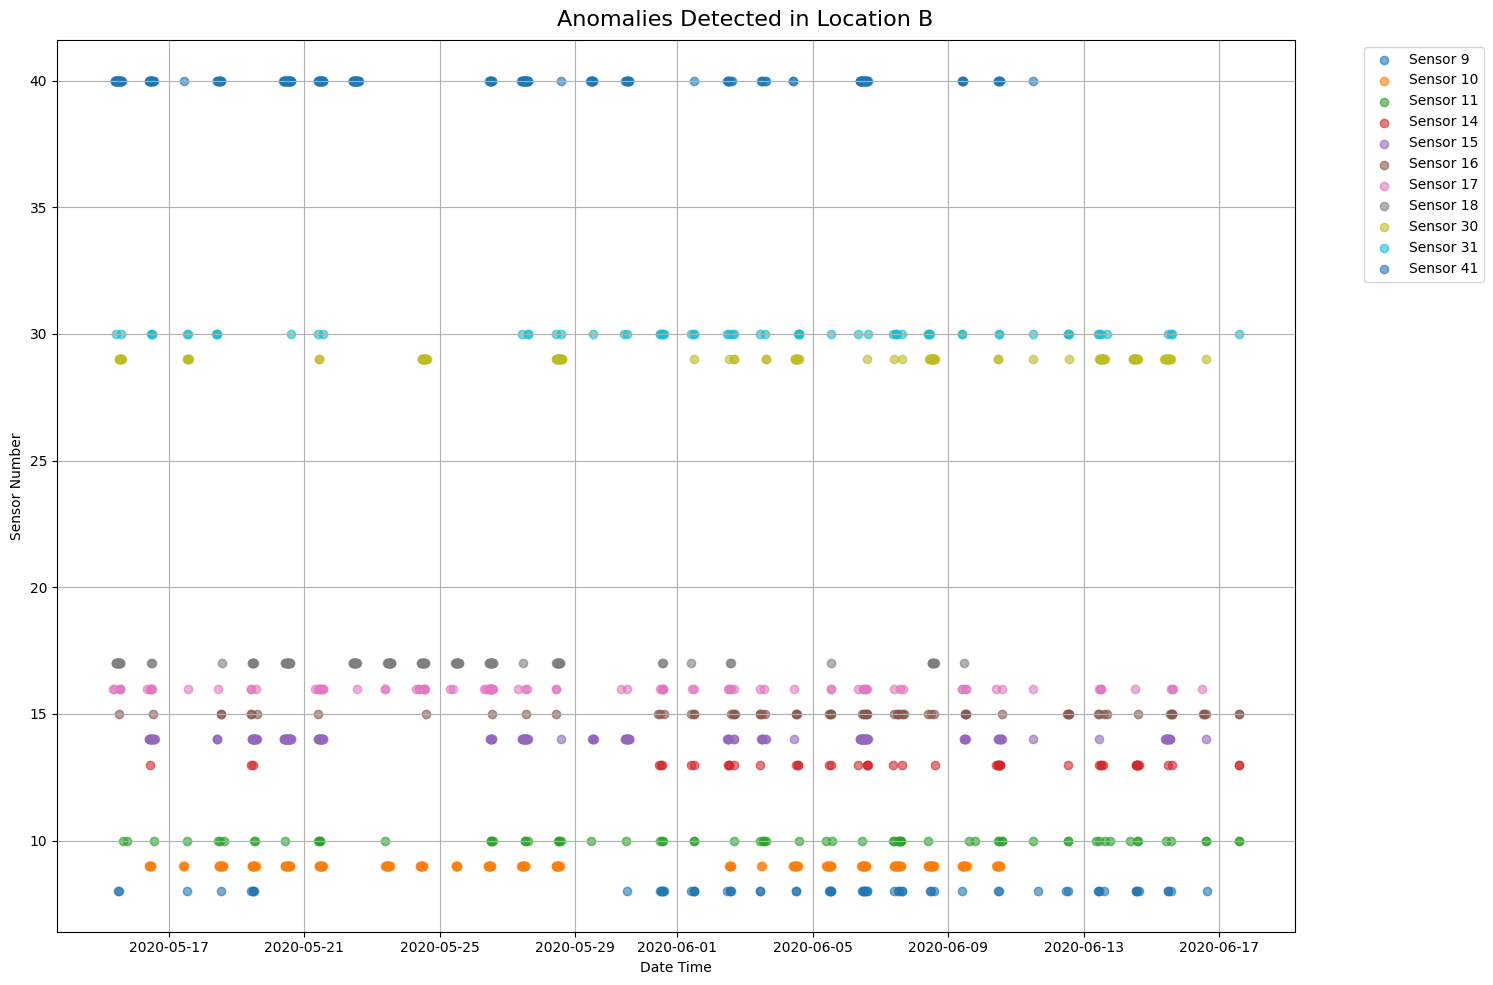

Gradient Boosting
************************************* Location A:  44
************************************* Location B:  44

Location A Overall Metrics:
Average MSE: 425.1359
Average R2 Score: 0.9966

Location B Overall Metrics:
Average MSE: 223.5140
Average R2 Score: 0.9982

Detected 8 anomalies for sensor 0

Detected 30 anomalies for sensor 1

Detected 25 anomalies for sensor 2

Detected 22 anomalies for sensor 19

Detected 21 anomalies for sensor 23

Detected 20 anomalies for sensor 24

Detected 20 anomalies for sensor 25

Detected 30 anomalies for sensor 26

Detected 27 anomalies for sensor 27

Detected 21 anomalies for sensor 36

Detected 23 anomalies for sensor 42

Detected 29 anomalies for sensor 43

Detected 73 anomalies for sensor 8

Detected 229 anomalies for sensor 9

Detected 81 anomalies for sensor 10

Detected 45 anomalies for sensor 13

Detected 166 anomalies for sensor 14

Detected 83 anomalies for sensor 15

Detected 85 anomalies for sensor 16

Detected 128 anomalies

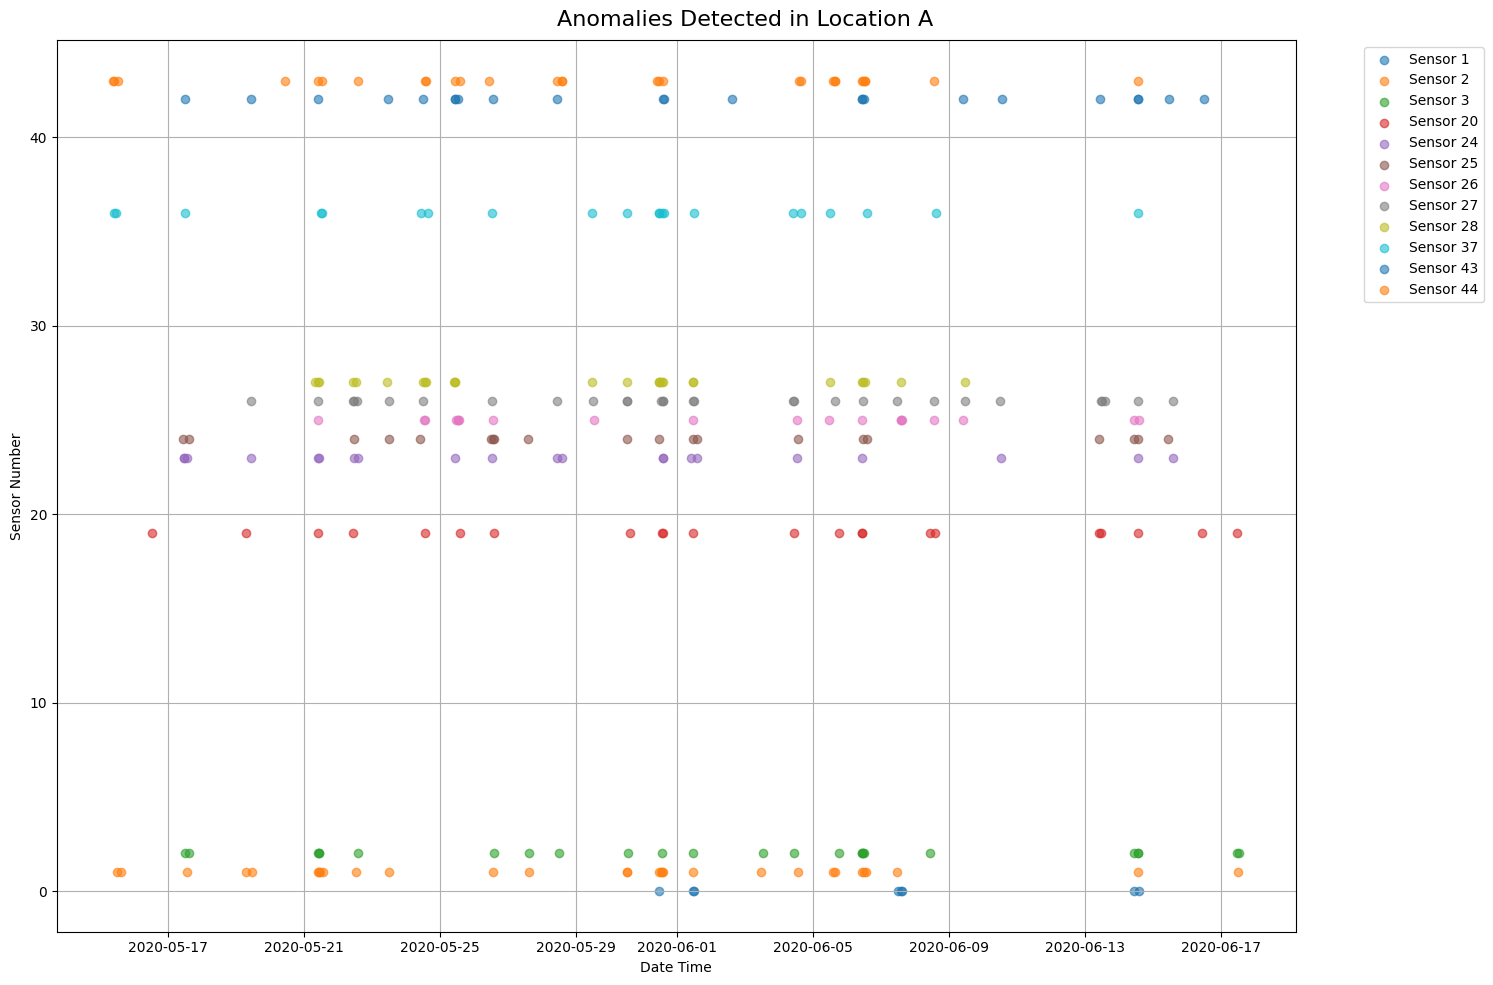

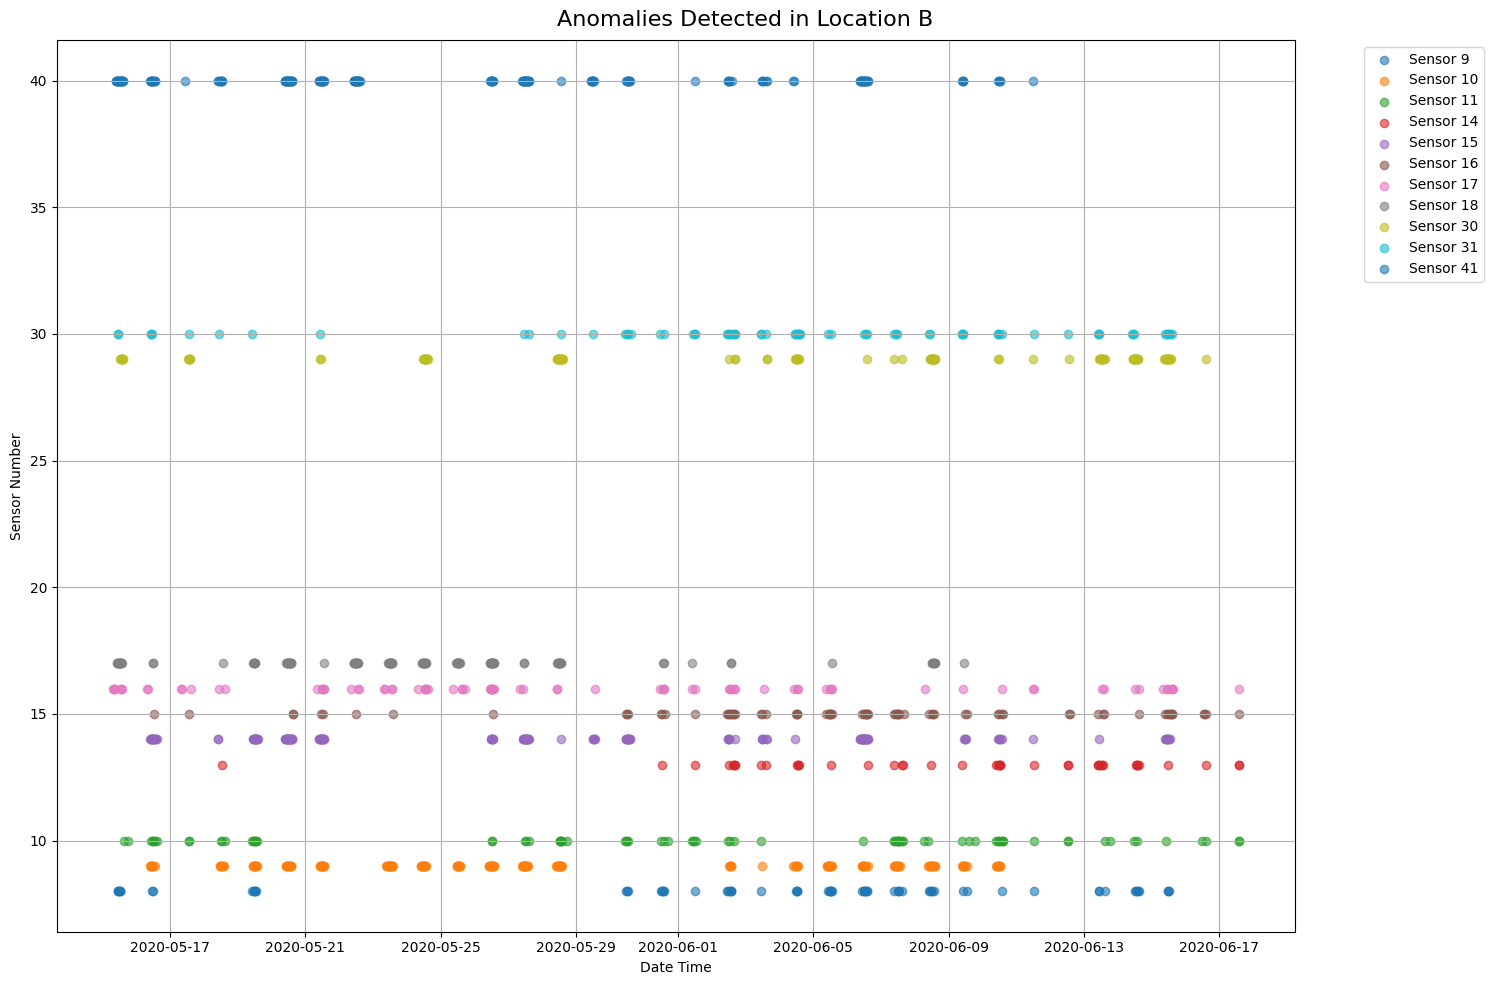

finished


In [60]:
# Initialize lists to store processed data for each location
final_locA = []
final_locB = []
print("Linear Regression")
# Function to train model for a sensor
def train_sensor_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, r2

# Lists to store models and their performance metrics
locA_models = []
locB_models = []
locA_models,locB_models = preprocess_data(locA_solar_sensor.copy(),locB_solar_sensor.copy())
test_model(locA_models,locB_models,0)

print("Random Forest")
# Initialize lists to store processed data for each location
final_locA = []
final_locB = []

# Function to train model for a sensor
def train_sensor_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, r2

# Lists to store models and their performance metrics
locA_models = []
locB_models = []

locA_models,locB_models = preprocess_data(locA_solar_sensor.copy(),locB_solar_sensor.copy())
test_model(locA_models,locB_models,1)

print("Gradient Boosting")
# Initialize lists to store processed data for each location
final_locA = []
final_locB = []

# Function to train model for a sensor
def train_sensor_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, r2

# Lists to store models and their performance metrics
locA_models = []
locB_models = []
locA_models,locB_models = preprocess_data(locA_solar_sensor.copy(),locB_solar_sensor.copy())
test_model(locA_models,locB_models,2)

print("finished")

